In [2]:
%load_ext autoreload
import glob
import nibabel 
import nilearn
import pandas as pd
import numpy as np
import h5py
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook, tqdm
from joblib import Parallel, delayed
import logging
from IPython.core.debugger import set_trace
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import re
import os
import shutil
import pickle
import torchio

import torch
import torch.nn.functional as F

from utils import create_dicts, normalize, load, video, video_comparison

from multiprocessing import cpu_count
N_CPU = cpu_count()

from IPython.core.display import display, HTML
from celluloid import Camera

SEED = 42
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
labels_components = np.load('metadata/label_info.npy', allow_pickle=True).item()
nonsingle_component_keys = {k for k,v in labels_components.items() if len(v['cc3d'][0]) != 2}

labels_broken = {'55','54', '47','43','37','33','25','12', '9','6','3','70NS','73NS', '73NS',
                  'n42', 'n83', 'n30', 'n27', 'n31', 'n20', 'n10', 'n8', 'n3'
                 }.union(nonsingle_component_keys)

len(labels_broken)

35

In [11]:
nonsingle_component_keys

{'15',
 '2',
 '36',
 '5',
 '54',
 '58',
 '61',
 '72NS',
 '83',
 '85NS',
 '87NS',
 'n50',
 'n53',
 'n56'}

# Create paths dicts

for each label associated with subject there will be a dict of paths for different features

### Original (w/o affine)

In [5]:
# root = '/media/tom/ibulygin/fcd_data/radiologist/'
# root_label = os.path.join(root, 'label')

# feature_paths_templates = {
#       'label':os.path.join(root,'label_orig/{label}.nii.gz'),
#       'mask':[os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprageSagP2Iso_desc-brain_mask.nii.gz'),
#              os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprNsSagP2Iso08Mm_desc-brain_mask.nii.gz'),
#              os.path.join(root, 'fmriprep/sub-{label}/anat/*Mprage_desc-brain_mask.nii.gz'),
#              os.path.join(root, 'fmriprep/sub-{label}/anat/*SagT1Mprage08MmIsoP2Fov256_desc-brain_mask.nii.gz'),
#              os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprageSagP2IsoOrig_desc-brain_mask.nii.gz'),
#              os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprageTraP2Iso_desc-brain_mask.nii.gz'),
#              os.path.join(root, 'fmriprep/sub-{label}/anat/*IrCorHiRes_desc-brain_mask.nii.gz'),
#               ],
#       'T1w':[os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprageSagP2Iso_desc-preproc_T1w.nii.gz'),
#             os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprNsSagP2Iso08Mm_desc-preproc_T1w.nii.gz'),
#             os.path.join(root, 'fmriprep/sub-{label}/anat/*Mprage_desc-preproc_T1w.nii.gz'),
#             os.path.join(root, 'fmriprep/sub-{label}/anat/*SagT1Mprage08MmIsoP2Fov256_desc-preproc_T1w.nii.gz'),
#             os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprageSagP2IsoOrig_desc-preproc_T1w.nii.gz'),
#             os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprageTraP2Iso_desc-preproc_T1w.nii.gz'),
#             os.path.join(root, 'fmriprep/sub-{label}/anat/*acq-IrCorHiRes_desc-preproc_T1w.nii.gz'),
#             ],
#         }

# paths_dict = create_dicts(root_label,
#                          feature_paths_templates,
#                          label_extractor=lambda x: x.split('.')[0],
#                          broken_labels=labels_broken)

In [5]:
# len(paths_dict)

In [6]:
# paths_dict.keys()

In [7]:
# for k,v in paths_dict.items():
#     print(k)
#     print(v['T1w'])
#     print(v['mask'])
#     print('\n')

In [8]:
# d = load(paths_dict['n63'])
# d['label'].shape, d['mask'].shape, d['T1w'].shape

In [9]:
# label_orig = d['label_orig']
# label = d['label']
# brain = d['T1w']

In [10]:
# plt.ioff()
# camera = video_comparison([brain, brain],
#                           [label_orig.transpose(2,0,1), label_orig.transpose(2,1,0)],
#                           n_slides=128,
#                           titles=['(2,0,1)', '(2,1,0)'])
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [11]:
# for k,v in paths_dict.items():
#     data_dict = load(v)
#     print(k, 'label shape:', data_dict['label'].shape, 'T1w shape:',  data_dict['T1w'].shape)

### Brats

In [12]:
# root = '/media/tom/ibulygin/MICCAI_BraTS2020_TrainingData/'

# feature_paths_templates = {
#       'seg':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_seg.nii.gz'),
#       't1':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_t1.nii.gz'),
#       't1ce':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_t1ce.nii.gz'),
#       't2':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_t2.nii.gz'),
#       'flair':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_flair.nii.gz'),
#     }

### MNI152 (preprocessed)

In [12]:
pirogov_labels = set(filter(lambda x: len(re.findall('^\d+',x)) > 0 , labels_components.keys()))
labels_broken = labels_broken.union(pirogov_labels)

In [49]:
root = '/media/tom/ibulygin/fcd_data/radiologist/'
root_label = os.path.join(root, 'label')

feature_paths_templates = {
      'label':os.path.join(root, 'label/{label}.nii.gz'),
      'mask':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-brain_mask.nii.gz'),
      'curv':os.path.join(root, 'curv/norm-{label}.nii.gz'),
      'sulc':os.path.join(root, 'sulc/norm-{label}.nii.gz'),
      'thickness':os.path.join(root, 'thickness/norm-{label}.nii.gz'),
      'bT1': os.path.join(root, 'fmriprep/sub-{label}/anat/n_blurring-in-volume.nii.gz'),
#       'bT1':[os.path.join(root, 'bluring-T1/sub-{label}_T1blurring-in-volume.nii.gz'), # non-norm
#             os.path.join(root, 'fmriprep/sub-{label}/anat/n_blurring-in-volume.nii.gz')], # norm?
      'bT2':os.path.join(root, 'bluring-T2/sub-{label}_T2blurring-in-volume.nii.gz'), # non-norm!
      'T1w':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'),
#       'flair':os.path.join(root, 'Flair/sub-{label}.nii.gz'),
#       'T2':os.path.join(root, 'T2/{label}.nii'),
      'CSF':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-CSF_probseg.nii.gz'),
      'GM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-GM_probseg.nii.gz'),
      'WM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-WM_probseg.nii.gz'),
      'entropy':os.path.join(root, 'entropy/n_sub-{label}_entropy.nii.gz'),
      'cr':os.path.join(root, 'fmriprep/sub-{label}/anat/*n_T2_CR-{label}.nii.gz')
    }

paths_dict = create_dicts(root_label,
                         feature_paths_templates,
                         label_extractor=lambda x: x.split('.')[0],
                         broken_labels=labels_broken) 

No curv for n23
No curv for n46
No curv for G180
No curv for n29
No curv for n21
No curv for G256
No curv for n25
No entropy for n12
No curv for n33
No curv for n58


In [50]:
features = set(feature_paths_templates.keys()) - {'label'}

len(paths_dict)

73

In [54]:
# datas = {}
# for k in tqdm(paths_dict.keys()):
#     datas[k] = load(paths_dict[k])


In [19]:
features_min = defaultdict(list)
features_max = defaultdict(list)

for k,data in tqdm(datas.items()):
    mask = data['mask'] > 0
    for f,v in data.items():
        features_min[f].append(v[mask].min())
        features_max[f].append(v[mask].max())        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [10:39<00:00,  8.75s/it]


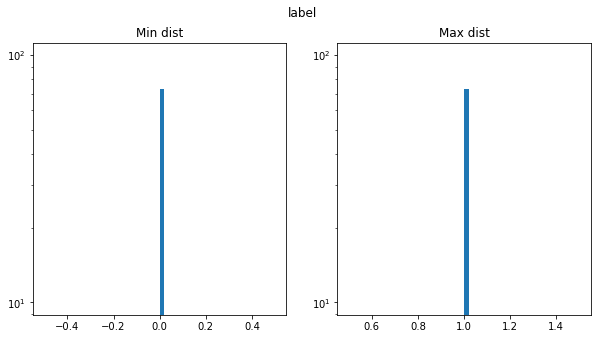

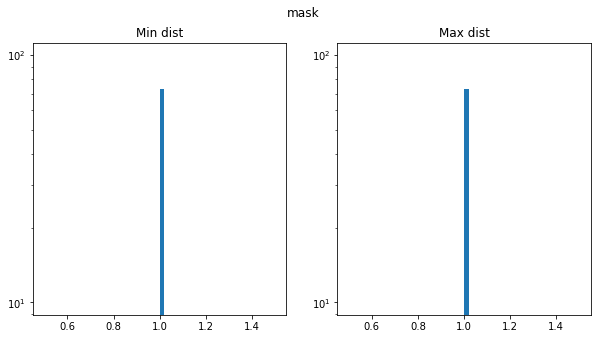

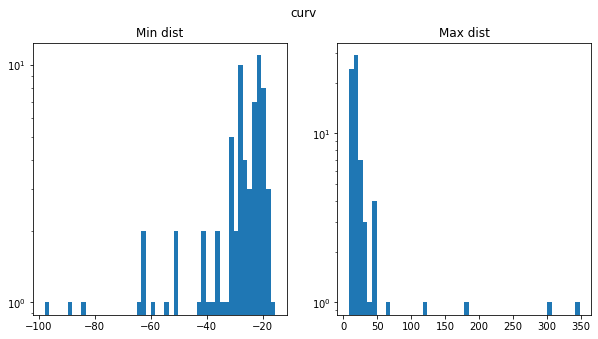

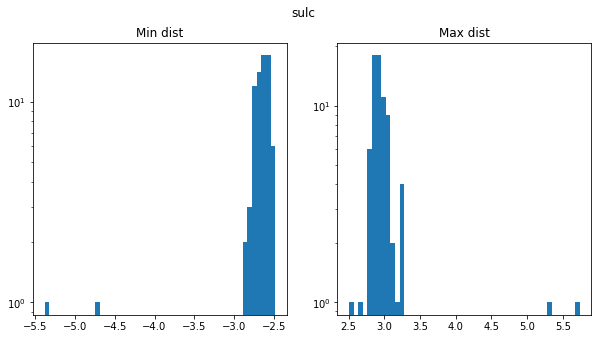

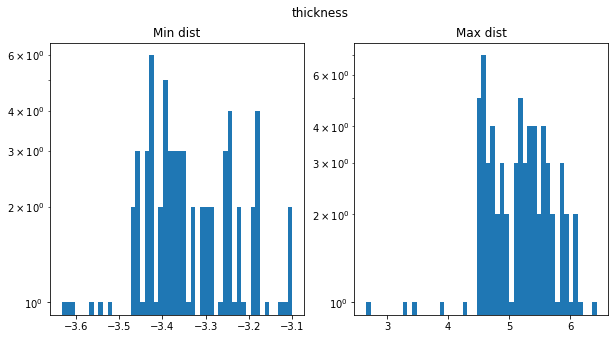

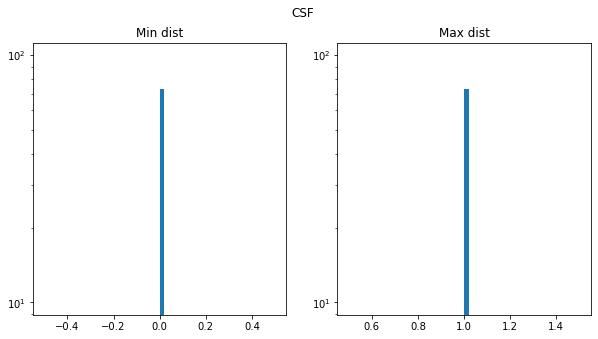

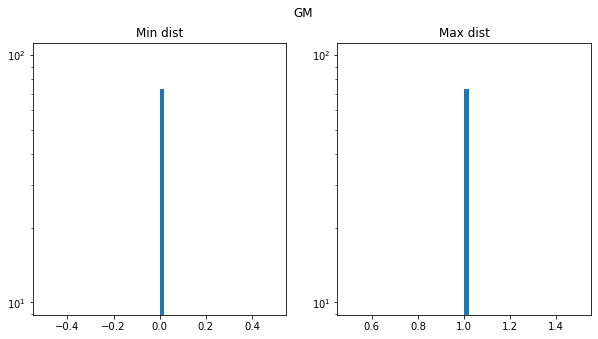

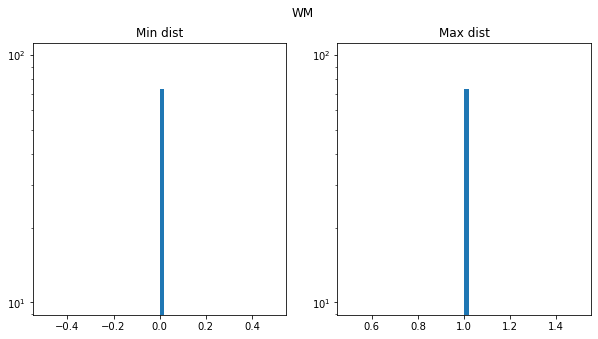

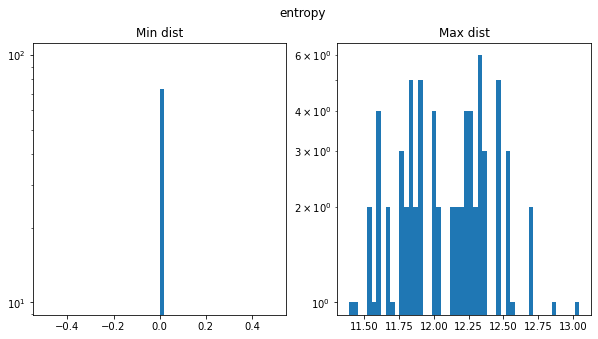

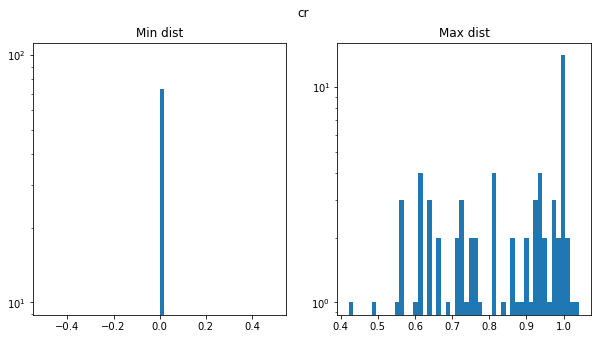

In [20]:
for f in features_min.keys():
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(10,5))
    
    axes[0].hist(features_min[f], bins=50)
    axes[0].set_yscale('log')
    axes[0].set_title('Min dist')
    
    axes[1].hist(features_max[f], bins=50)
    axes[1].set_yscale('log')
    axes[1].set_title('Max dist')
    
    fig.suptitle(f) 
plt.show()

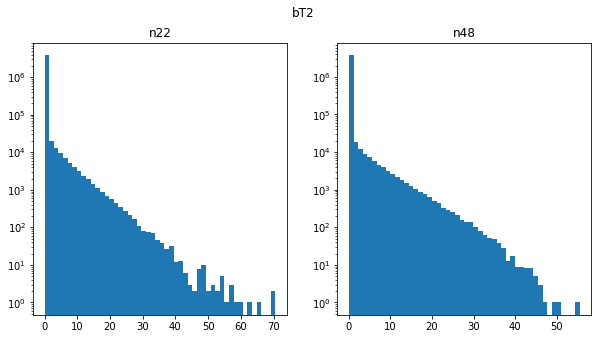

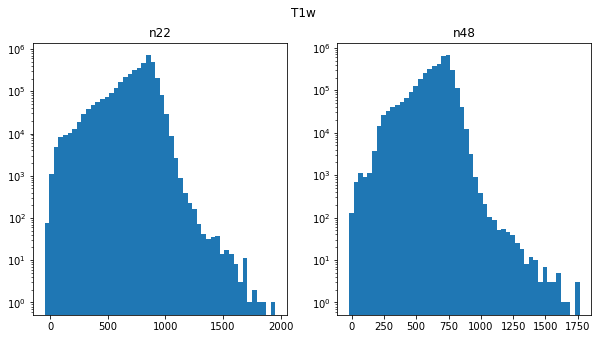

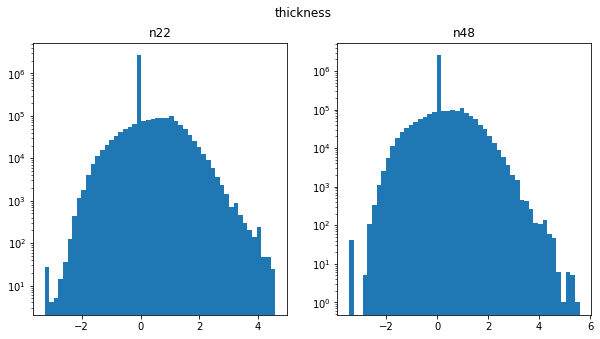

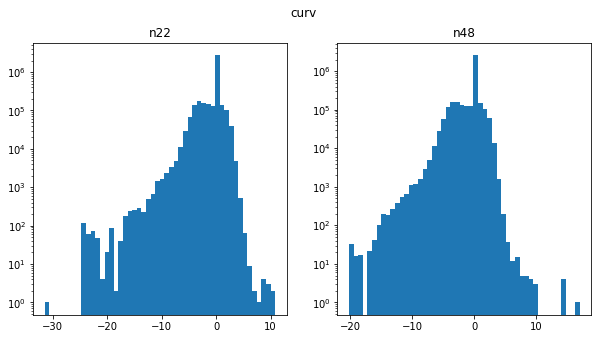

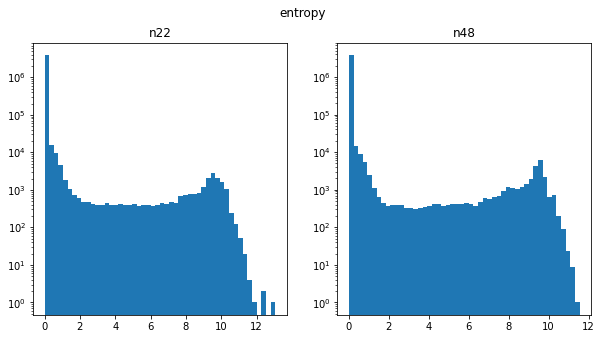

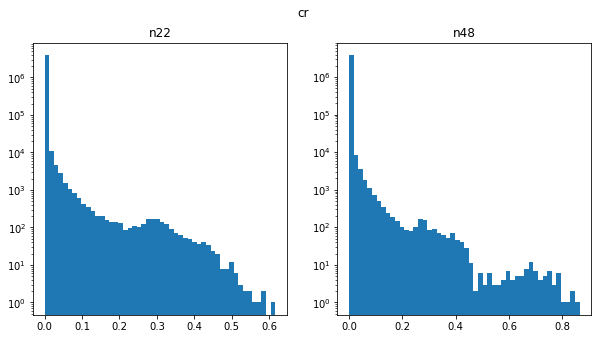

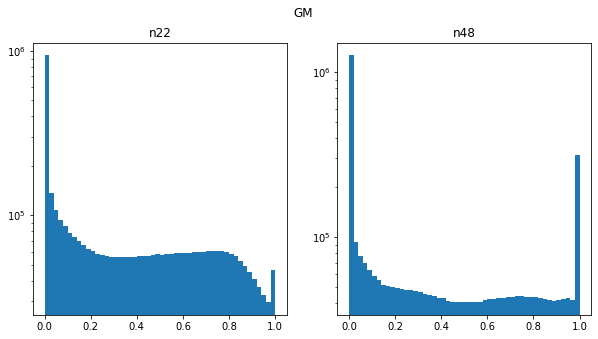

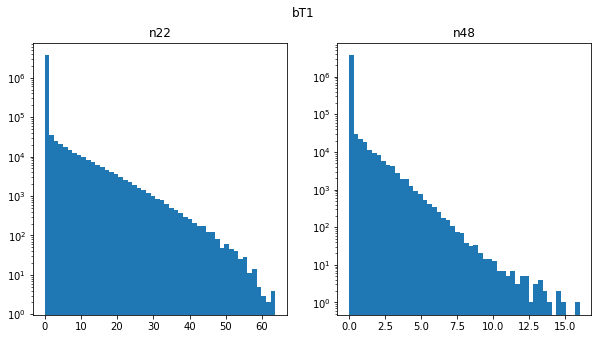

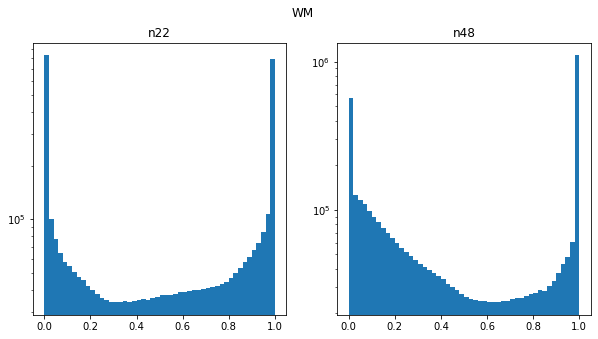

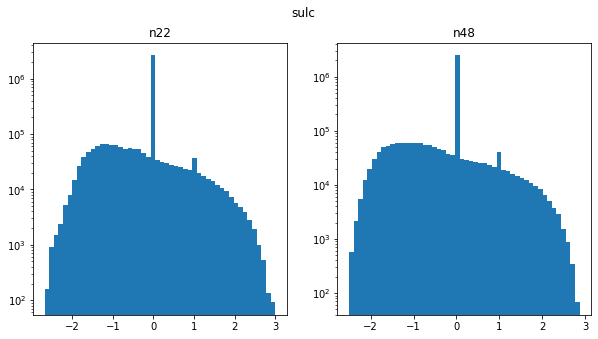

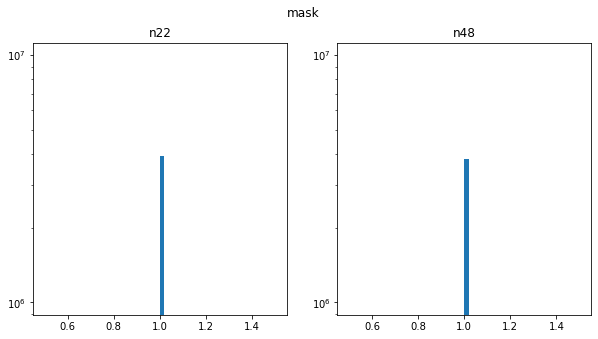

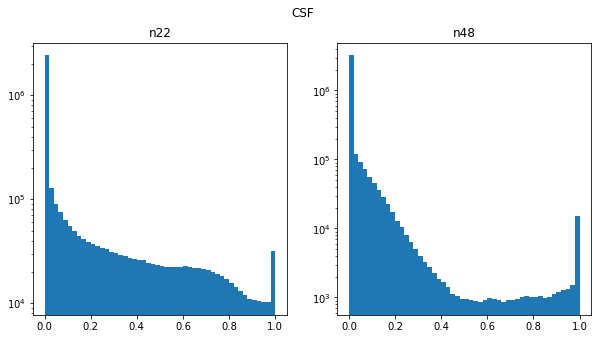

In [201]:
for f in features:
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(10,5))
    for i,(k,data) in enumerate(datas.items()):
        axes[i].hist(data[f][data['mask'] > 0], bins=50)
        axes[i].set_yscale('log')
        axes[i].set_title(k)
    fig.suptitle(f)
plt.show()

In [185]:
mask = data['mask']
t1w = data['T1w']*mask

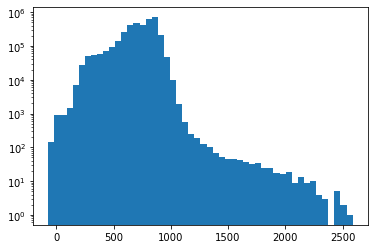

In [190]:
values = t1w[mask > 0]
plt.hist(values, bins=50)
plt.yscale('log')
plt.show()

In [ ]:
values_ = (values - np.median(values)) / 

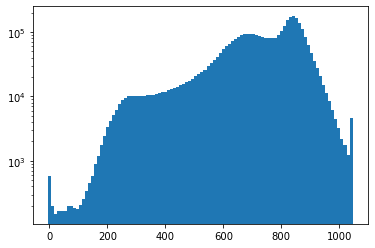

In [192]:
plt.hist(np.clip(values, np.percentile(values, 0.01), np.percentile(values, 99.9)), bins=100)
plt.yscale('log')
plt.show()

# Visualize different features mean over coronal axis 

In [66]:
def percentile_clip(featuremap, mask):
    
    '''
    mask - binary
    '''
    
    values = featuremap[mask]
    v_min =  np.percentile(values, 0.01), 
    v_max = np.percentile(values, 99.9)
    featuremap[mask] = np.clip(values, v_min, v_max)
    
    return featuremap

In [176]:
n_labels_vis = 10

features_subsample = defaultdict(dict)
features_hist = defaultdict(dict)

random_labels = np.random.choice(list(paths_dict.keys()), size=n_labels_vis, replace=False)

for label in random_labels:
    mask_path = paths_dict[label]['mask']
    mask = nibabel.load(mask_path).get_fdata()
    
    for feature_name in tqdm(features):
        path = paths_dict[label][feature_name]
        
        featuremap = nibabel.load(path).get_fdata() * mask
        
        featuremap = percentile_clip(featuremap, mask > 0)
        
        features_subsample[label][feature_name] = featuremap.mean(-2)
        features_hist[label][feature_name] = np.histogram(featuremap[mask > 0], bins=100)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.04s/it]


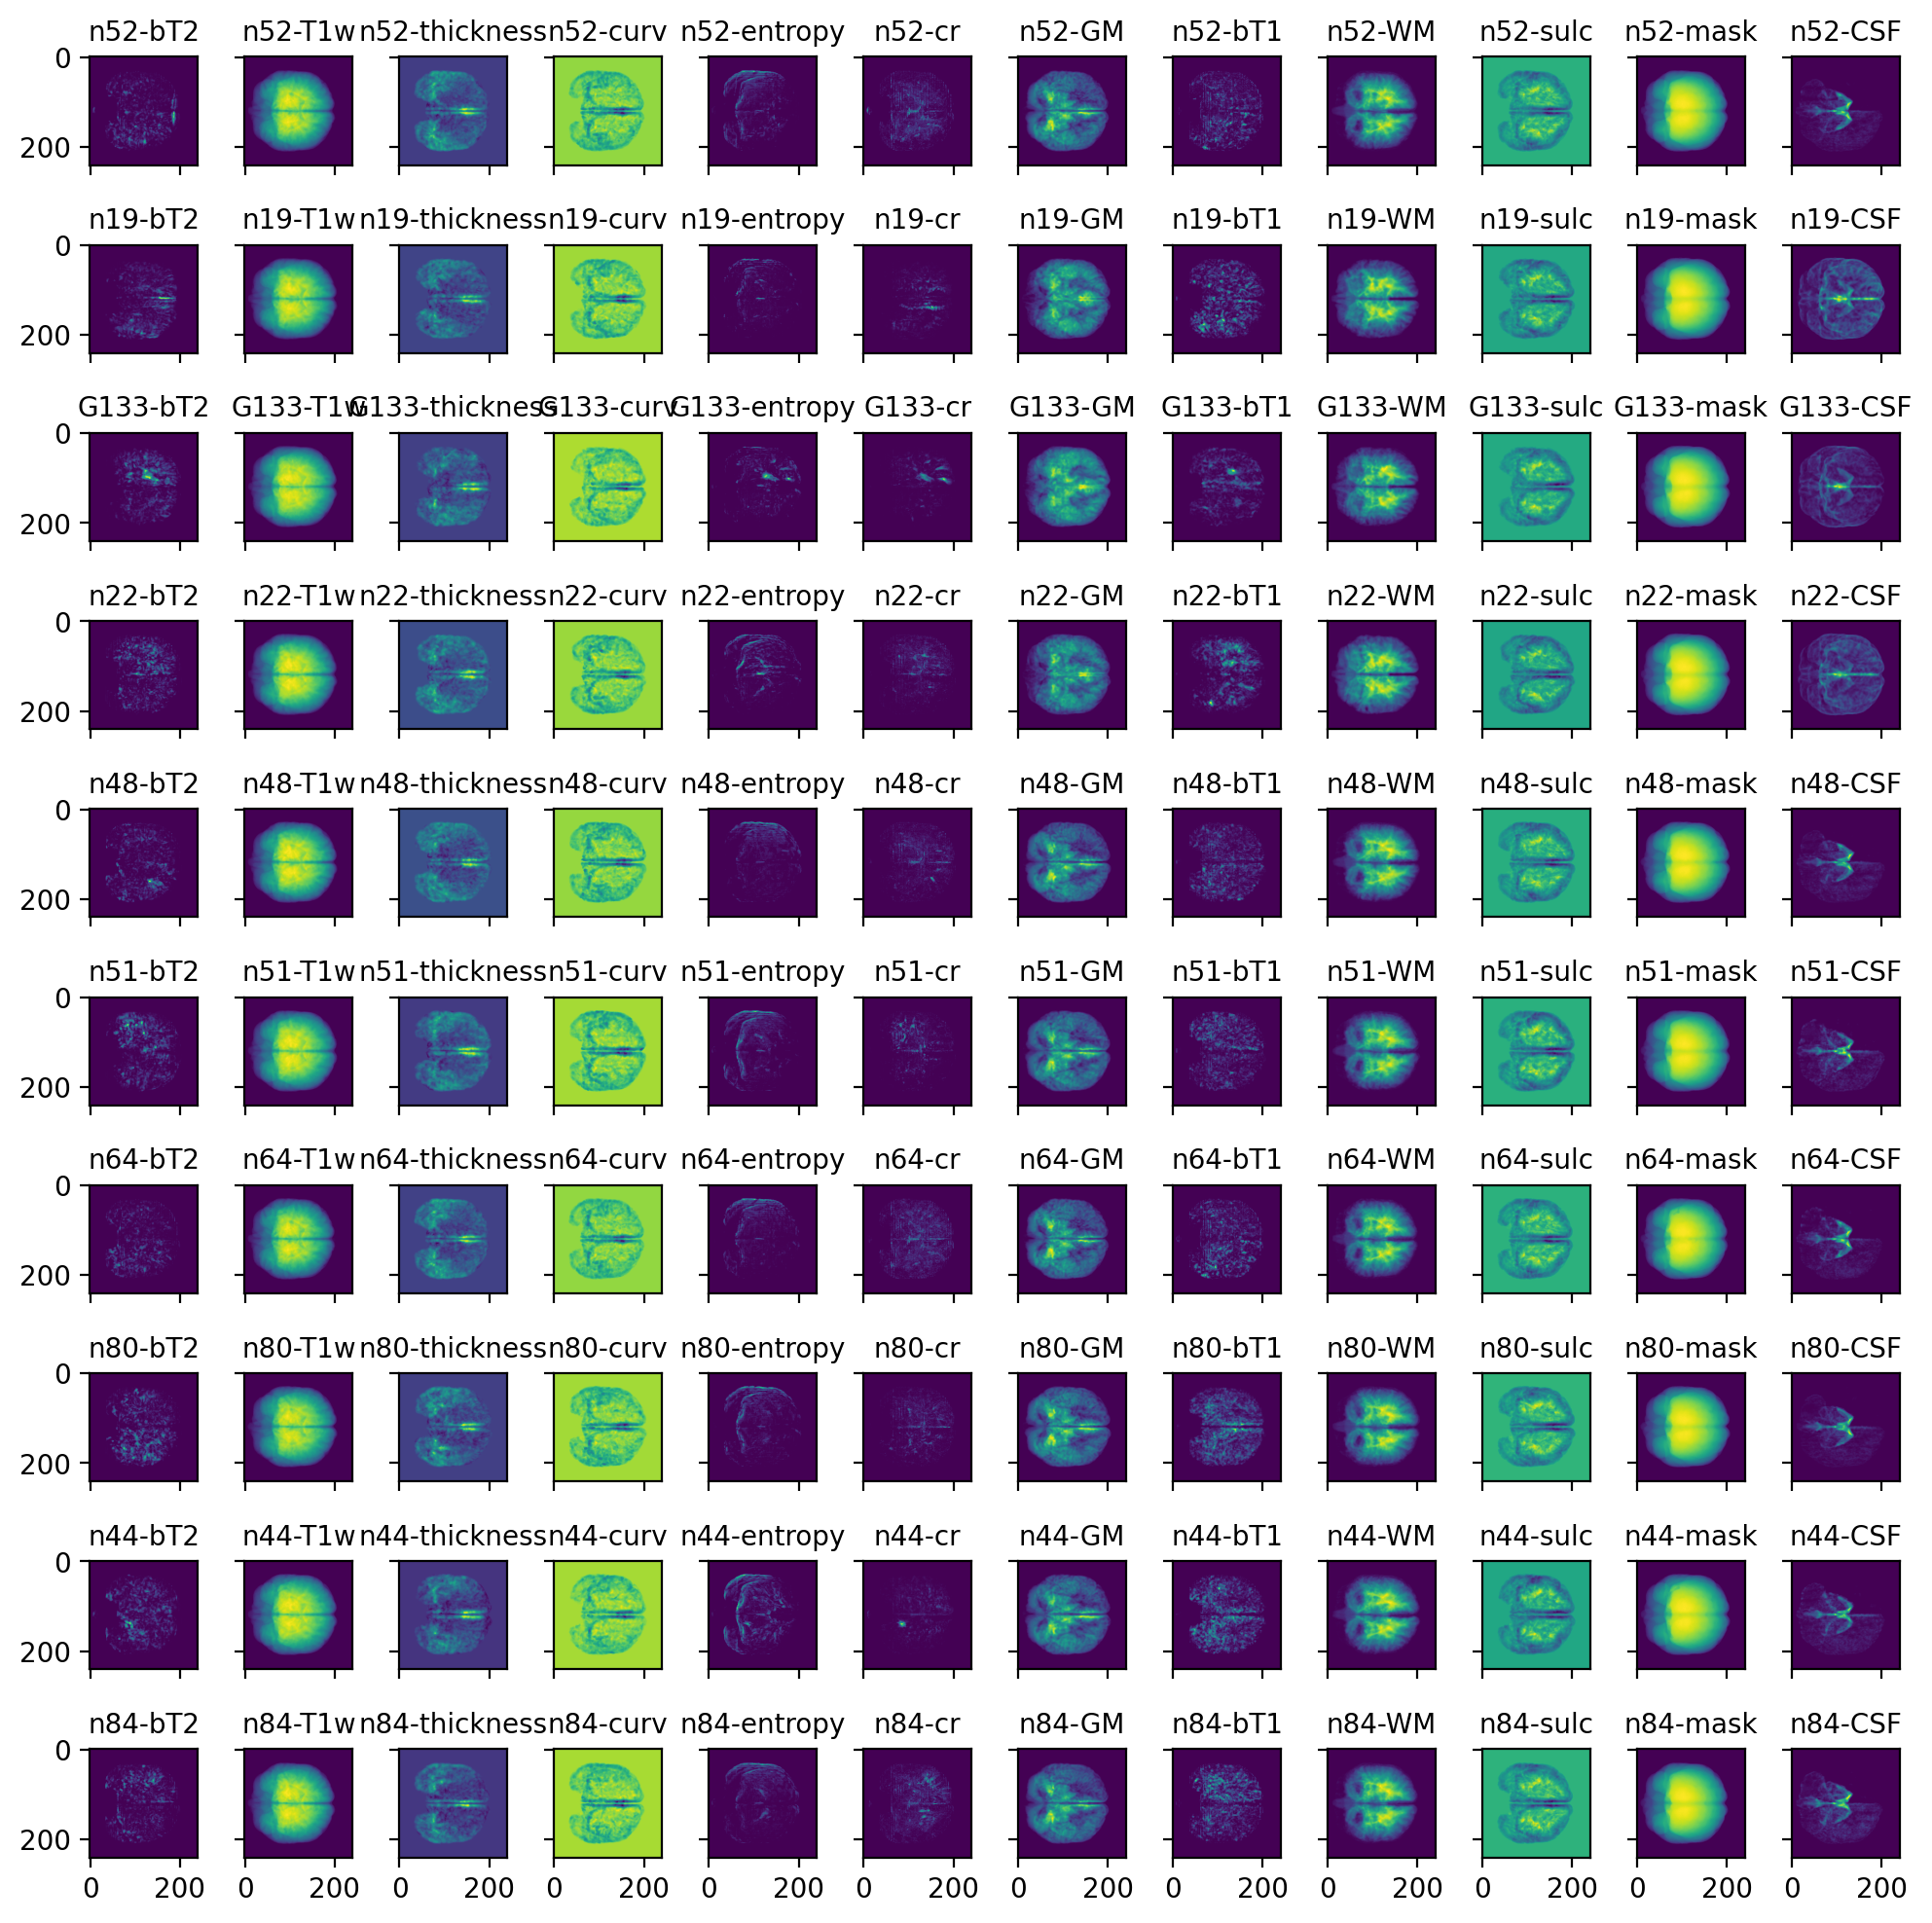

In [180]:
fig, axes = plt.subplots(nrows=n_labels_vis, ncols=len(features), 
                         dpi=200, sharex=True, sharey=True, figsize=(10,10))

for i,label in enumerate(random_labels):
    for j,feature_name in enumerate(features):
        
        f_mean = features_subsample[label][feature_name]
        
        axes[i,j].imshow(f_mean)
        axes[i,j].set_title(f'{label}-{feature_name}', fontsize=10)
        
plt.tight_layout()
                
plt.show()

In [181]:
# plt.bar(features_hist[label][feature_name][1][1:],
#                             features_hist[label][feature_name][0], width=0.01)
# plt.show()

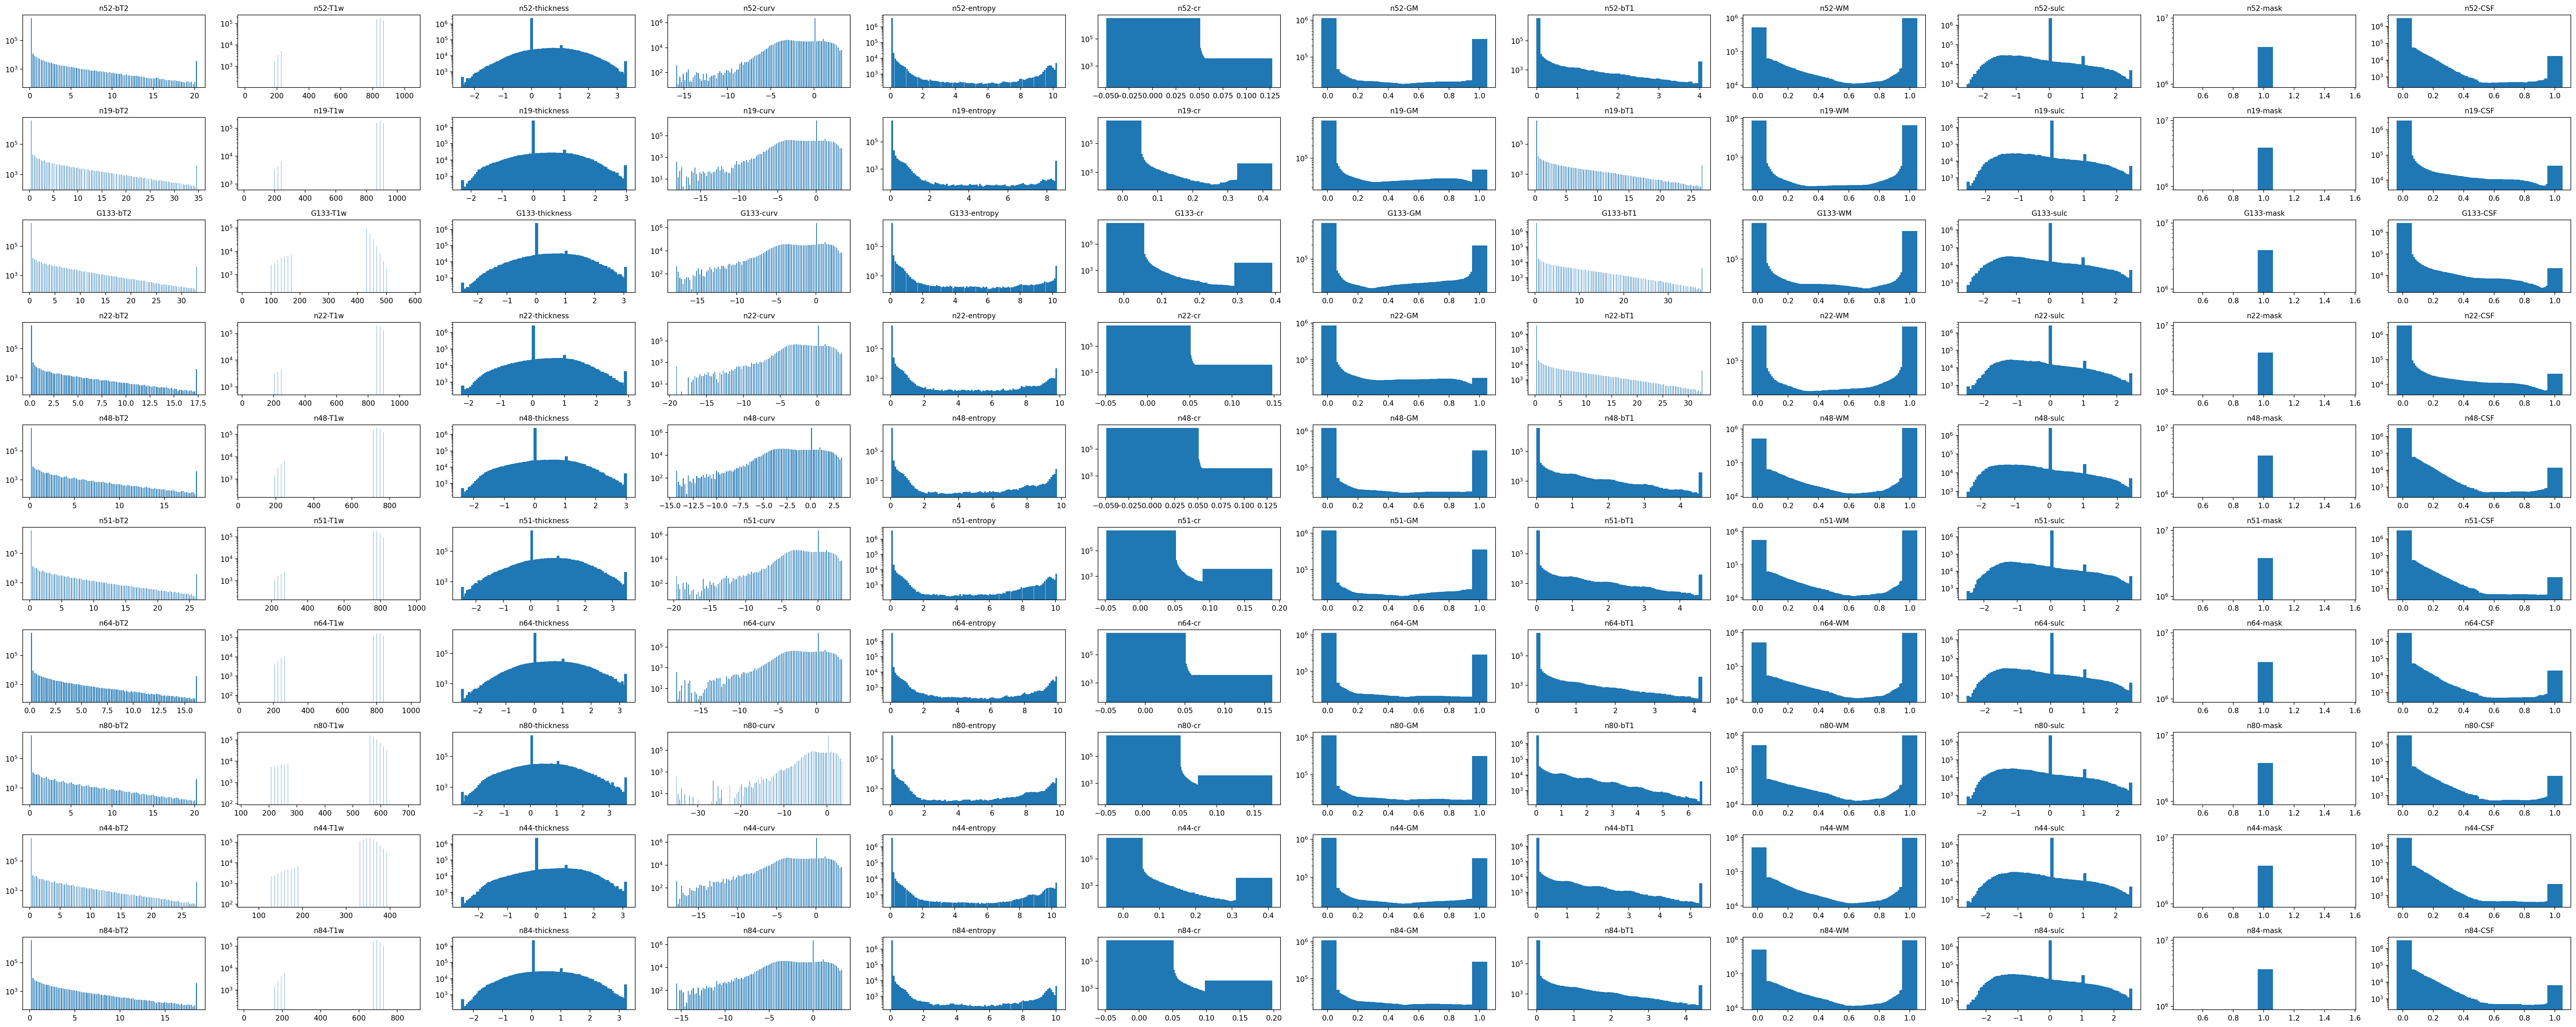

In [182]:
fig, axes = plt.subplots(nrows=len(random_labels), ncols=len(features), 
                         dpi=200, figsize=(50,20)) 

for i,label in enumerate(random_labels):
    for j,feature_name in enumerate(features):
        
        axes[i,j].bar(features_hist[label][feature_name][1][1:],
                            features_hist[label][feature_name][0], width=0.1)
        axes[i,j].set_title(f'{label}-{feature_name}', fontsize=10)
        axes[i,j].set_yscale('log')

plt.tight_layout()
                
plt.show()

# Create tensors

In [64]:
def make_tensor(root, name, pdict, save=True, Log=print):
        
    if save:
        filename = os.path.join(root, f'tensor_{name}')
        if os.path.exists(filename):
            try:
                torch.load(filename)
                Log(f'Tensor found: {name}')
                return None
            except:
                Log(f'tensor was not loaded, recalculating: {name}')
                os.remove(filename)
                
    try:
        data_dict = load(pdict)
    except:
        Log(f'pdict was not loaded: {name}')
        return None
    
    ################
    # MAKE TENSORS #
    ################
    
    mask = data_dict['mask'] > 0 # it should be bool!
    label = (data_dict['label'] > 1e-10).astype(int)
    
    assert label.sum() < mask.sum()
    
    # add .transpose(2,1,0) - for original labels 
    label = label * mask.astype(int) 
    
    mask_tensor_torch = torch.tensor(mask, dtype=torch.float32)
    label_tensor_torch = torch.tensor(label, dtype=torch.float32)
    
    torch_tensor = {'mask':mask_tensor_torch,
                    'label':label_tensor_torch}
    
    for k,v in data_dict.items():
        if not k in ['mask', 'label']:
            v = percentile_clip(v, mask)
            data = normalize(v, mask) # zero background, normalize in `mask` region
            data_torch = torch.tensor(data, dtype=torch.float32)
            torch_tensor[k] = data_torch
    if save:
        torch.save(torch_tensor, filename, _use_new_zipfile_serialization=False)
        
    Log(f'Calculated: {name}')
    
    return torch_tensor

### Check that created tensor is valid

In [67]:
%%time
tensor = make_tensor('./', 'n32', paths_dict['n32'], save=False)

Calculated: n32
CPU times: user 47.9 s, sys: 5.11 s, total: 53.1 s
Wall time: 13.6 s


In [48]:
# for k,v in paths_dict.items():
#     data_dict = load(v)
#     print(k, data_dict['label'].shape, data_dict['T1w'].shape)

In [61]:
# for k,v in tensor.items():
#     print(k,v.shape, v.max(), v.min())

In [62]:
# plt.ioff()
# camera = video_comparison([t.numpy() for t in tensor.values()],
#                           n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

### Creating tensors

In [68]:
tensors_root = '/media/tom/ibulygin/fcd_data/tensors_nG/'

In [69]:
logfile = 'make_tensor.log'
if os.path.isfile(logfile):
    os.remove(logfile)

logger = logging.getLogger('make_tensor')
logger.addHandler(logging.FileHandler(logfile))

_ = Parallel(n_jobs=N_CPU//3)(delayed(make_tensor)(tensors_root, k, v, True, logger.warning) \
                        for k,v in tqdm(paths_dict.items()))

 36%|████████████████████████████████████████████████▍                                                                                       | 26/73 [00:27<00:57,  1.22s/it]Calculated: n68
Calculated: n37
Calculated: n64
Calculated: n62
Calculated: n13
Calculated: n74
Calculated: n76
Calculated: n28
Calculated: n55
Calculated: n17
Calculated: n82
Calculated: n44
Calculated: n14
Calculated: n79
Calculated: n71
Calculated: G061
Calculated: n84
Calculated: n75
 53%|████████████████████████████████████████████████████████████████████████▋                                                               | 39/73 [04:19<05:01,  8.86s/it]Calculated: G258
Calculated: n65
Calculated: G015
Calculated: n38
Calculated: n32
Calculated: n67
Calculated: n15
Calculated: G371
Calculated: n9
Calculated: n36
Calculated: n81
Calculated: n11
Calculated: n41
Calculated: G177
Calculated: n45
Calculated: n35
Calculated: n73
 71%|█████████████████████████████████████████████████████████████████████████████████████

# Metadata

In [78]:
metadata = np.load('./metadata/metadata_fcd_nG.npy', allow_pickle=True).item()

In [86]:
labels = list(map(lambda x: x.split('tensor_')[1], os.listdir(tensors_root)))

In [55]:
def stratify(x):
    if x[0]=='n':
        return 0
    elif x[-2:] == 'NS':
        return 1
    elif x[0] == 'G':
        return 2
    else:
        return 3

In [56]:
clinic_labels = list(map(stratify, labels))

(array([59.,  0.,  0., 12.,  0.,  0., 15.,  0.,  0., 45.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

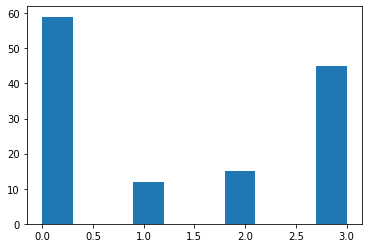

In [58]:
plt.hist(clinic_labels)
plt.show()

In [81]:
# train,test = train_test_split(labels, test_size=4, random_state=33) # , stratify=clinic_labels

In [87]:
test = ['n66', 'n70', 'n78', 'n15', 'n11', 'n5', 'G414', 'G258', 'G324']  #['38', '24', '1', '48', 'n15', 'n11', 'n5', 'G414', 'G258', 'G324']
train = labels.copy()

for rs in test:
    if rs in train:
        train.remove(rs)

In [88]:
len(test), len(train)

(9, 64)

In [89]:
metadata = {'train':train,
            'test':test}
np.save('metadata/metadata_fcd_nG.npy', metadata)